In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks
import tensorflow_probability as tfp

import sys
from pathlib import Path
sys.path.insert(0, str(Path("..").resolve()))

from utils import sample_batch, display

In [2]:
img_size = 32
n_components = 5
epochs = 10
batch_size = 128

In [3]:
(x_train, _), (_, _) = datasets.fashion_mnist.load_data()

### Preprocess the data

In [4]:
def preprocess(imgs):
    imgs = np.expand_dims(imgs, -1)
    imgs = tf.image.resize(imgs, (img_size, img_size)).numpy()
    return imgs


input_data = preprocess(x_train)

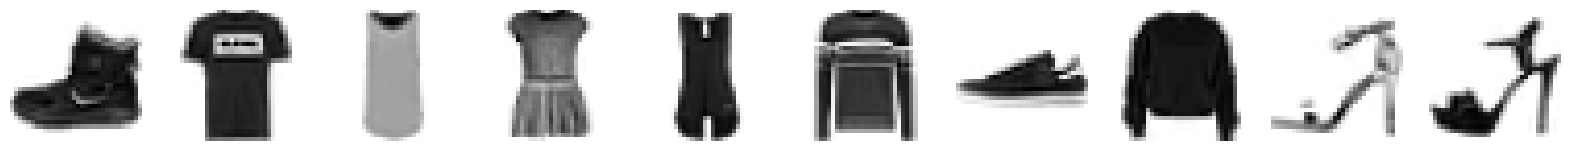

In [5]:
display(input_data)

### Model

In [6]:
# Define and build the PixelCNN distribution
dist = tfp.distributions.PixelCNN(
    image_shape=(img_size, img_size, 1),
    num_resnet=1,
    num_hierarchies=2,
    num_filters=32,
    num_logistic_mix=n_components,
    dropout_p=0.3,
)

dummy_input = tf.zeros((1, img_size, img_size, 1))
_ = dist.log_prob(dummy_input)

# Create a subclassed model
class PixelCNNModel(models.Model):
    def __init__(self, dist, **kwargs):
        super().__init__(**kwargs)
        self.dist = dist
        self._network = dist.network
        # Store reference to the network's variables and add regularizer attribute
        self._trainable_vars = []
        for var in self._network.trainable_variables:
            # Add the regularizer attribute that Keras expects
            if not hasattr(var, 'regularizer'):
                var.regularizer = None
            self._trainable_vars.append(var)
        
        self._non_trainable_vars = []
        for var in self._network.non_trainable_variables:
            if not hasattr(var, 'regularizer'):
                var.regularizer = None
            self._non_trainable_vars.append(var)
    
    def call(self, inputs, training=None):
        log_prob = self.dist.log_prob(inputs, training=training)
        self.add_loss(-tf.reduce_mean(log_prob))
        return log_prob
    
    @property
    def trainable_weights(self):
        return self._trainable_vars
    
    @property
    def non_trainable_weights(self):
        return self._non_trainable_vars

# Create the model
pixelcnn = PixelCNNModel(dist)

# Build it by calling it once
_ = pixelcnn(dummy_input)

print(f"Number of trainable weights: {len(pixelcnn.trainable_weights)}")
print(f"Total parameters: {sum([tf.size(w).numpy() for w in pixelcnn.trainable_weights])}")


Number of trainable weights: 108
Total parameters: 624990


### Train

In [7]:
pixelcnn.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
)

In [8]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def generate(self):
        return dist.sample(self.num_img).numpy()

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate()
        display(
            generated_images,
            n=self.num_img,
        )


img_generator_callback = ImageGenerator(num_img=2)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 4478.2644

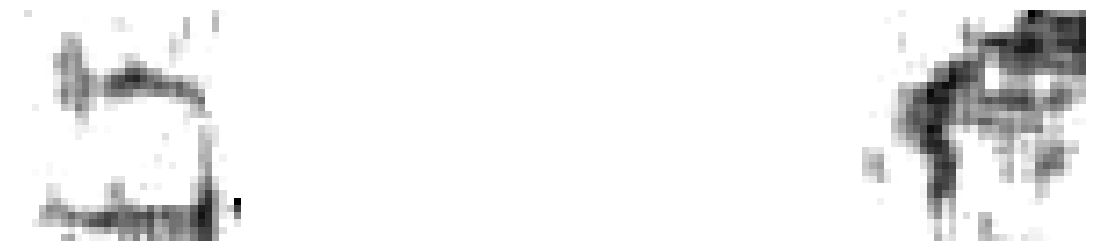

469/469 ━━━━━━━━━━━━━━━━━━━━ 914s 2s/step - loss: 3356.7334
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 2435.9180

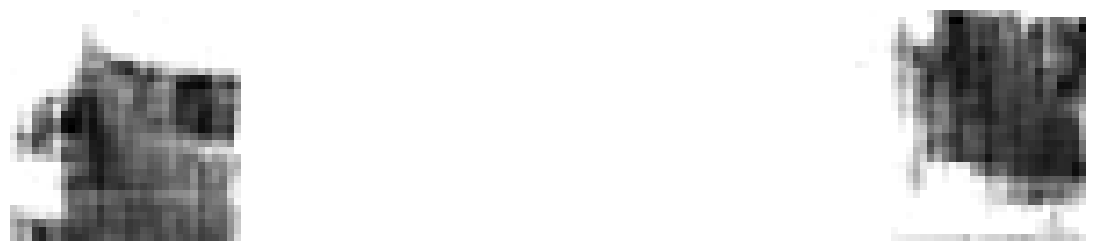

469/469 ━━━━━━━━━━━━━━━━━━━━ 919s 2s/step - loss: 2384.0110
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 2256.6408

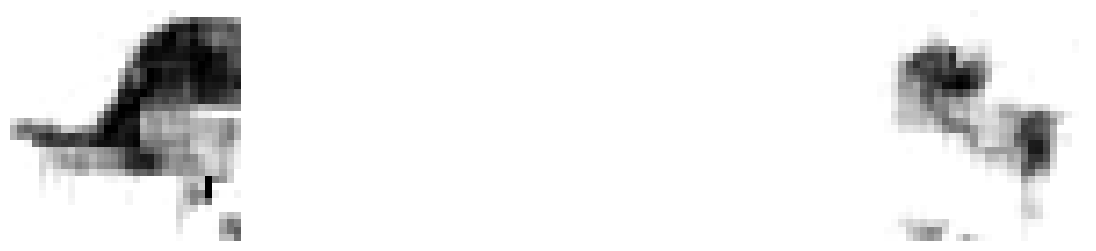

469/469 ━━━━━━━━━━━━━━━━━━━━ 889s 2s/step - loss: 2232.5481
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 2166.8858

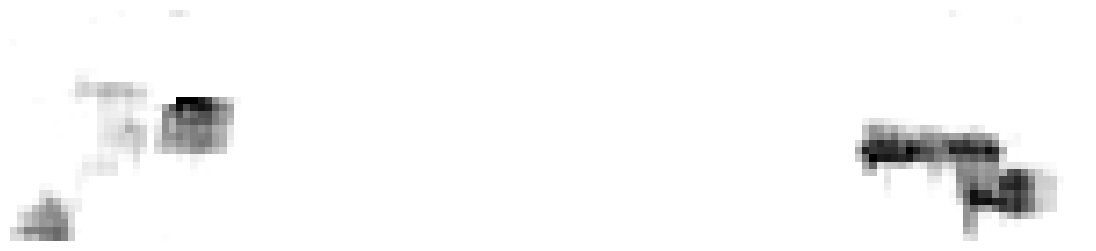

469/469 ━━━━━━━━━━━━━━━━━━━━ 1034s 2s/step - loss: 2151.3074
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 2110.5260

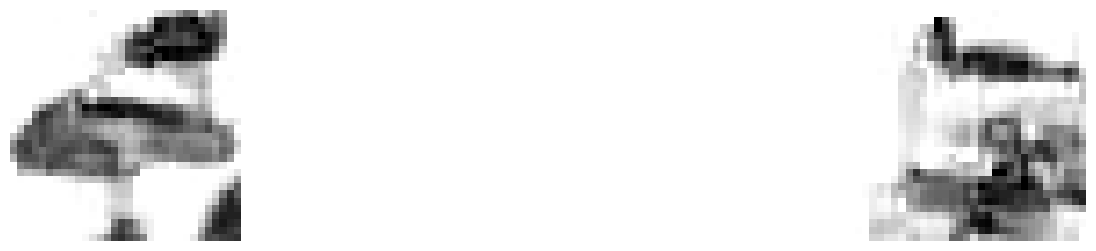

469/469 ━━━━━━━━━━━━━━━━━━━━ 2153s 5s/step - loss: 2096.5745
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 2063.3376

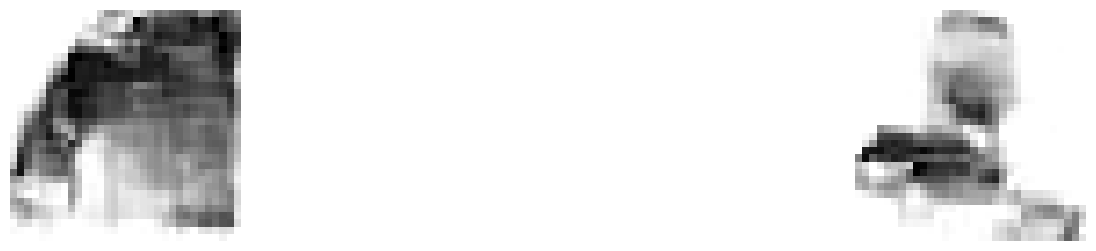

469/469 ━━━━━━━━━━━━━━━━━━━━ 1069s 2s/step - loss: 2060.6948
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 2036.7924

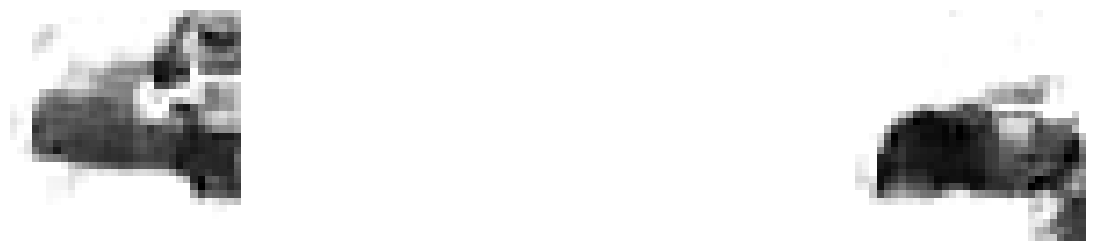

469/469 ━━━━━━━━━━━━━━━━━━━━ 1080s 2s/step - loss: 2024.9645
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 2002.6031

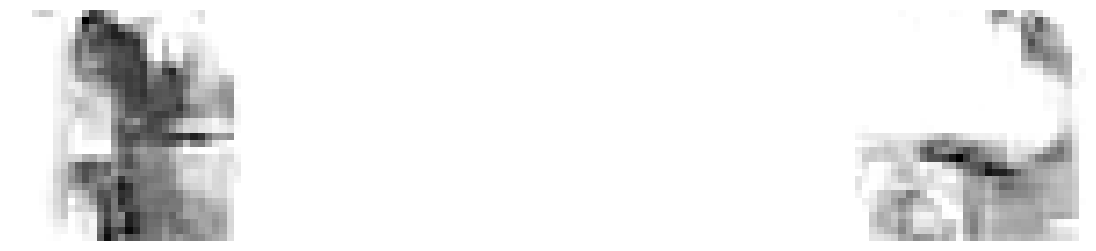

469/469 ━━━━━━━━━━━━━━━━━━━━ 1098s 2s/step - loss: 2000.5410
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - loss: 1974.6900 

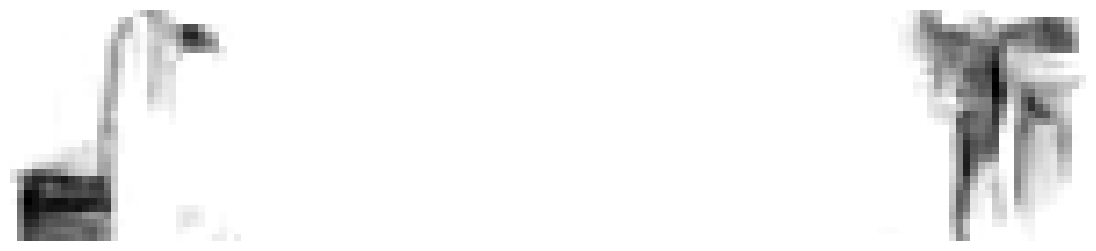

469/469 ━━━━━━━━━━━━━━━━━━━━ 5896s 13s/step - loss: 1967.3116
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1946.9539

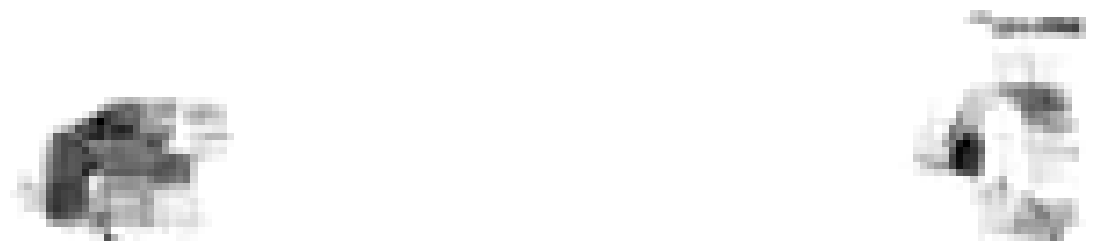

469/469 ━━━━━━━━━━━━━━━━━━━━ 933s 2s/step - loss: 1939.7007


In [9]:
pixelcnn.fit(
    input_data,
    batch_size=batch_size,
    epochs=epochs,
    verbose=True,
    callbacks=[tensorboard_callback, img_generator_callback],
)

### Generate new images

In [10]:
generated_images = img_generator_callback.generate()

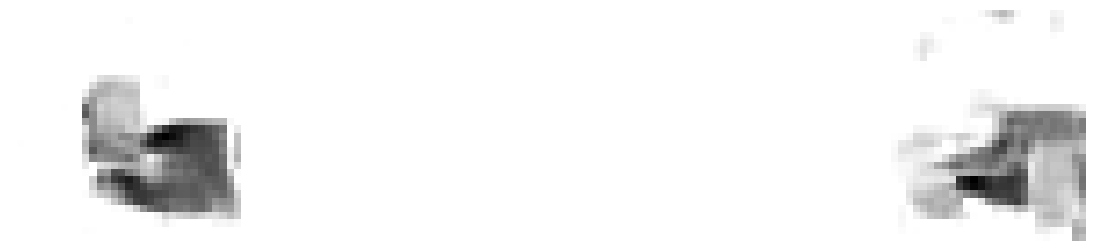

In [11]:
display(generated_images, n=img_generator_callback.num_img)